In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np

import shap
from sklearn import tree, ensemble
from sklearn import preprocessing, model_selection
from sklearn import metrics
from sklearn.datasets import make_blobs


from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets


%matplotlib inline

# Shap Toy

# Vinhos


## Leitura da Base 

In [75]:
df_wine = pandas.read_csv('../Data/dataset_vinhos.csv',sep=';')


wine_target_col = 'target'

wine_label_map = df_wine[['target', 'target_label']].drop_duplicates()

drop_cols = ['target_label']
df_wine.drop(drop_cols, axis=1, inplace=True)
print(df_wine.shape)
df_wine.head()

(5320, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0,red


# Transformação Variáveis Categóricas

In [76]:
categorical_cols = ['type']
encoder_map = {}

for cname in categorical_cols:
    encoder = preprocessing.OneHotEncoder(sparse=False)
    transformed = encoder.fit_transform(df_wine[[cname]])
    ohe_df = pandas.DataFrame(transformed, columns=[cname+'_'+cat for cat in encoder.categories_[0]])
    encoder_map[cname] = encoder
    
    df_wine = pandas.concat([df_wine, ohe_df], axis=1).drop(cname, axis=1)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,type_red,type_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,1.0,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,1.0,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,1.0,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,1.0,0.0
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0,1.0,0.0


## Treinamento Classificador

In [77]:

Y = df_wine[wine_target_col]
X = df_wine.drop(wine_target_col, axis=1)
wine_features = list(X.columns)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[wine_target_col] = ytrain
df_test[wine_target_col] = ytest


# model_wine = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 5)
# model_wine = ensemble.RandomForestClassifier(criterion='gini',
#                                            max_depth = 5,
#                                            n_estimators=100)
model_wine = ensemble.GradientBoostingClassifier(max_depth = 5,
                                                 n_estimators=100,
                                                 learning_rate = 0.1)


model_wine.fit(xtrain, ytrain)      
df_train['decision'] = model_wine.predict(xtrain)
df_test['decision']  = model_wine.predict(xtest)



df_train['probability'] = model_wine.predict_proba(xtrain)[:,1]
df_test['probability']  = model_wine.predict_proba(xtest)[:,1]

df_wine = pandas.concat((df_train, df_test), axis=0)

print(metrics.classification_report(df_wine[wine_target_col],
                              df_wine['decision'],
                              target_names = wine_label_map.target_label))

                 precision    recall  f1-score   support

baixa qualidade       0.85      0.78      0.81      1988
 alta qualidade       0.87      0.92      0.89      3332

       accuracy                           0.86      5320
      macro avg       0.86      0.85      0.85      5320
   weighted avg       0.86      0.86      0.86      5320



## SHAP 

In [78]:
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_wine)

### Individual Contribution of Features

In [81]:
def plot_shap_force_plot(data, sample_eval, features, matplotlib=True):

    if isinstance(sample_eval, int):
        sample_eval = [sample_eval]
    X= data.loc[sample_eval, features]
    if X.shape[0] > 500:
        X = X.sample(500)
    shap_values = explainer.shap_values(X)
    # visualize the sample_eval's explanation (use matplotlib=True to avoid Javascript)
    shap.force_plot(explainer.expected_value[0], shap_values[0], X,
                    feature_names = features,
                    matplotlib=matplotlib,
                    show=matplotlib)



interact(plot_shap_force_plot, 
         data = fixed(df_wine),
         sample_eval = list(df_wine.index.sort_values()),
         features = fixed(wine_features)) 

interactive(children=(Dropdown(description='sample_eval', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.plot_shap_force_plot(data, sample_eval, features, matplotlib=True)>

### Grouped Force Plot

In [86]:
group_col = 'type_red'
group_val = 1
data = df_wine
features = wine_features

sample_eval = data[group_col] == group_val
X= data.loc[sample_eval, features]
if X.shape[0] > 500:
    X = X.sample(500)
shap_values = explainer.shap_values(X)
# visualize the sample_eval's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0], shap_values, X,
                feature_names = features)

### Group Dependence Plot

In [93]:
group_col = 'type_red'
group_val_list = list(df_wine[group_col].sort_values().unique())
max_samples = 2000


def plot_shap_dependence_plot(data, group_col, group_val,
                              features, feature_val, interaction_feature):
    print('Grouping over column', group_col)
    sample_eval = data[group_col] == group_val
    X = data.loc[sample_eval, features]
    if X.shape[0] > max_samples:
        print('Selecting random', max_samples, 'samples')
        X = X.sample(max_samples)
        
    shap_values = explainer.shap_values(X)
    # create a dependence plot to show the effect of a single feature across the whole dataset
    shap.dependence_plot(feature_val, 
                         shap_values, 
                         X, 
                         feature_names=features,
                         interaction_index=interaction_feature)


interact(plot_shap_dependence_plot, 
         data = fixed(df_wine),
         group_col = fixed(group_col), 
         group_val = group_val_list,
         features = fixed(wine_features),
         feature_val = wine_features,
         interaction_feature = ['auto']+wine_features)

interactive(children=(Dropdown(description='group_val', options=(0.0, 1.0), value=0.0), Dropdown(description='…

<function __main__.plot_shap_dependence_plot(data, group_col, group_val, features, feature_val, interaction_feature)>

### Shap Swarm Importance Plot 

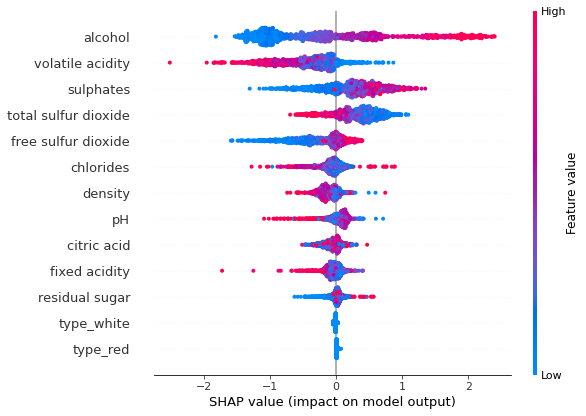

In [94]:

group_col = 'type_red'
group_val = 1
data = df_wine
features = wine_features

sample_eval = data[group_col] == group_val
X= data.loc[sample_eval, features]
if X.shape[0] > max_samples:
    X = X.sample(max_samples)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=features)

### Shap Importance Plot 

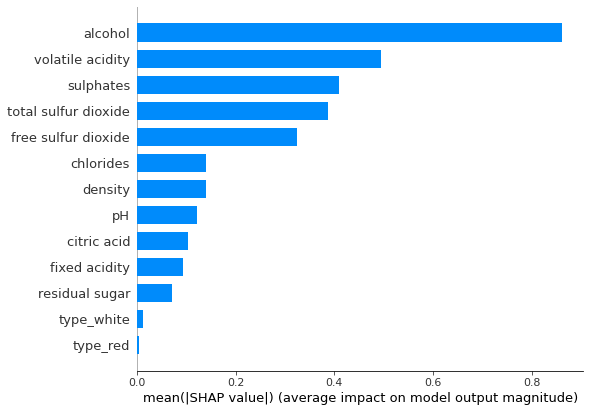

In [95]:


group_col = 'type_red'
group_val = 1
data = df_wine
features = wine_features

sample_eval = data[group_col] == group_val
X= data.loc[sample_eval, features]
if X.shape[0] > max_samples:
    X = X.sample(max_samples)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names=features,  plot_type="bar")



# Íris 

## Leitura dos Dados 

In [25]:
df_iris = pandas.read_csv('../Data/dataset_iris.csv',sep=';')

iris_label_map = df_iris[['target', 'target_label']].drop_duplicates()

drop_cols = ['target_label']
df_iris.drop(drop_cols, axis=1, inplace=True)

print(df_iris.shape)

iris_target_col = 'target'

df_iris.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Treinamento do Classificador 

In [26]:

Y = df_iris[iris_target_col]
X = df_iris.drop(iris_target_col, axis=1)

# train/test
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(X, Y, test_size=0.2)

df_train = xtrain.copy()
df_test = xtest.copy()
df_train['train_set'] = 1
df_test['train_set'] = 0
df_train[iris_target_col] = ytrain
df_test[iris_target_col] = ytest


model_iris = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 2)
model_iris.fit(xtrain, ytrain)      
df_train['decision'] = model_iris.predict(xtrain)
df_test['decision']  = model_iris.predict(xtest)
for icls in iris_label_map.target.unique():
    xclass = xtrain[ytrain==icls]
    idx = df_train[iris_target_col] == icls
    df_train.loc[idx,'probability'] = model_iris.predict_proba(xclass)[:,icls]
    xclass = xtest[ytest==icls]
    idx = df_test[iris_target_col] == icls
    df_test.loc[idx,'probability']  = model_iris.predict_proba(xclass)[:,icls]

df_iris = pandas.concat((df_train, df_test), axis=0)

## Matriz de Confusão 

[Text(0, 0.5, 'setosa'), Text(0, 1.5, 'versicolor'), Text(0, 2.5, 'virginica')]

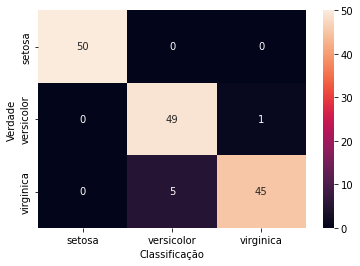

In [27]:
cm = metrics.confusion_matrix(df_iris[iris_target_col],
                              df_iris['decision'])
                              
sns.heatmap(cm, annot=True, fmt = '.0f')

plt.xlabel('Classificação')
plt.ylabel('Verdade')
plt.gca().set_xticklabels(iris_label_map.target_label.values)
plt.gca().set_yticklabels(iris_label_map.target_label.values)

## Relatório de Classificação 

In [28]:
print(metrics.classification_report(df_iris[iris_target_col],
                              df_iris['decision'],
                              target_names = iris_label_map.target_label))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.91      0.98      0.94        50
   virginica       0.98      0.90      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



## Distribuição de Probabilidade 

In [23]:

def plot_dist_class(class_name):
    iclass = iris_label_map[iris_label_map.target_label == class_name].target.values[0]
    prob = model_iris.predict_proba(X)[:,iclass]
    
    plt.figure(figsize=(6,4))
    for i in iris_label_map.target.unique():
        plt.hist(prob[Y == i], bins=np.linspace(0,1,10),
#                  histtype ='stepfilled',
                 alpha=0.3,
                 lw=2,
                 label=iris_label_map[iris_label_map.target == i].target_label)
                     
        
    plt.title('Distribuição de Probabilidade por Classe')
    plt.ylabel('Quantidade de Amostras')
    plt.xlabel('Probabilidade Espécie ' + class_name)
    plt.xlim((0,1))
    plt.grid()
    plt.legend()
    plt.show()

interact(plot_dist_class, class_name = iris_label_map.target_label) 


interactive(children=(Dropdown(description='class_name', options=('setosa', 'versicolor', 'virginica'), value=…

<function __main__.plot_dist_class(class_name)>

## Curva ROC 

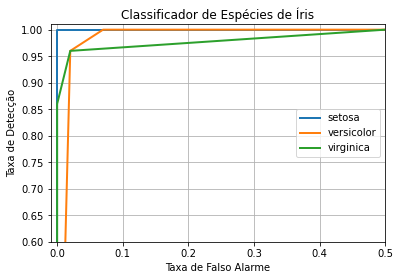

In [24]:
for class_name in iris_label_map.target_label:
    iclass = iris_label_map[iris_label_map.target_label == class_name].target.values[0]
    prob = model_iris.predict_proba(X)[:,iclass]
    clas = Y == iclass

    fpr, tpr, thr = metrics.roc_curve(clas,
                              prob)
    plt.plot(fpr, tpr, '-', lw=2, label=class_name)

plt.legend(loc='right')
plt.title('Classificador de Espécies de Íris')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')
plt.xlim((-0.01, 0.5))
plt.ylim((0.6, 1.01))
plt.show()
